# Введение в искусственные нейронные сети
# Урок 4. Сверточные нейронные сети

## Практическое задание

- реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
- оценить рост точности при увеличении глубины сети (больше слоев)

In [14]:
import numpy as np
import tensorflow as tf
from __future__ import print_function
import tensorflow.keras as keras # расскоментируйте эту строку, чтобы начать обучение
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.utils import plot_model 
import matplotlib.pyplot as plt
import os

In [15]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [16]:


# установка параметров нейросети
batch_size = 32
num_classes = 10
epochs = 1
data_augmentation = False
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [17]:
data_augmentation = True

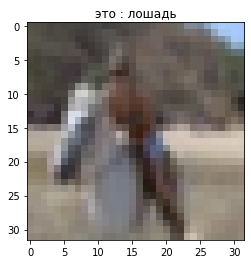

In [18]:
N = 9013

plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[np.argmax(y_test[N,:])])
plt.show()

In [19]:
x_train.shape[1:]

(32, 32, 3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


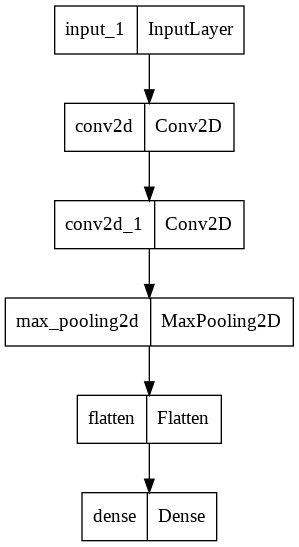

In [9]:
# Exp 1
# Возьмем за основу простую модель: 2 свертки, пулинг, плоский и выходной слой

first_input = Input(shape=(x_train.shape[1:])) #(32, 32, 3)
x11= Conv2D(32, (3, 3),activation='relu',padding = 'same')(first_input)
x11= Conv2D(32, (3, 3),activation='relu',padding = 'same')(x11)
x11= MaxPooling2D(pool_size=(2, 2))(x11)
x11= Flatten()(x11)
first_dense=Dense(num_classes, activation='softmax')(x11)

model_stek = Model(inputs=first_input, outputs=first_dense)
ada_grad = tf.keras.optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=0.0)
sgd = tf.keras.optimizers.SGD()
model_stek.compile(optimizer=sgd, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


plot_model(model_stek,'model_stek.png')

In [10]:
model_stek.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 10)                81930     
                                                             

In [65]:
hist = model_stek.fit(x_train, y_train, epochs = 5, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 15s 12ms/step - loss: 1.9190 - accuracy: 0.3170 - val_loss: 1.6894 - val_accuracy: 0.4073
Epoch 2/5
1250/1250 [==============================] - 12s 10ms/step - loss: 1.5892 - accuracy: 0.4403 - val_loss: 1.5473 - val_accuracy: 0.4538
Epoch 3/5
1250/1250 [==============================] - 14s 11ms/step - loss: 1.4487 - accuracy: 0.4850 - val_loss: 1.4046 - val_accuracy: 0.5043
Epoch 4/5
1250/1250 [==============================] - 14s 11ms/step - loss: 1.3390 - accuracy: 0.5276 - val_loss: 1.3279 - val_accuracy: 0.5253
Epoch 5/5
1250/1250 [==============================] - 22s 18ms/step - loss: 1.2455 - accuracy: 0.5611 - val_loss: 1.2743 - val_accuracy: 0.5519


val_accuracy: 0.5519

это наша самая простая базовая модель с 92 тыс обучаемых параметров

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


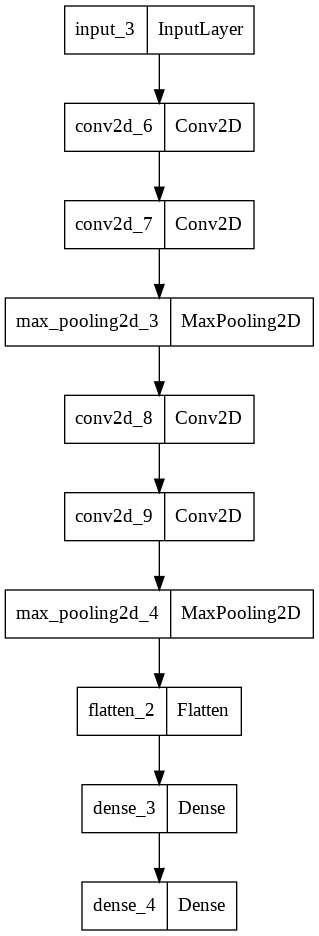

In [20]:
# Exp 2
# Добавим внутренних слоев для первой модели

first_input = Input(shape=(x_train.shape[1:])) #(32, 32, 3)
x11= Conv2D(32, (3, 3),activation='relu',padding = 'same')(first_input)
x11= Conv2D(32, (3, 3),activation='relu',padding = 'same')(x11)
x11= MaxPooling2D(pool_size=(2, 2))(x11)
x11= Conv2D(16, (3, 3),activation='relu',padding = 'same')(x11)
x11= Conv2D(16, (3, 3),activation='relu',padding = 'same')(x11)
x11= MaxPooling2D(pool_size=(2, 2))(x11)
x11= Flatten()(x11)
x11=Dense(512, activation='relu')(x11)
first_dense=Dense(num_classes, activation='softmax')(x11)

model_stek = Model(inputs=first_input, outputs=first_dense)
ada_grad = tf.keras.optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=0.0)
sgd = tf.keras.optimizers.SGD()
model_stek.compile(optimizer=sgd, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


plot_model(model_stek,'model_stek.png')

In [21]:
model_stek.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 16)        4624      
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 16)        2320      
                                                           

In [13]:
hist = model_stek.fit(x_train, y_train, epochs = 5, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 136s 108ms/step - loss: 2.0184 - accuracy: 0.2718 - val_loss: 1.8165 - val_accuracy: 0.3551
Epoch 2/5
1250/1250 [==============================] - 135s 108ms/step - loss: 1.6598 - accuracy: 0.4087 - val_loss: 1.5776 - val_accuracy: 0.4335
Epoch 3/5
1250/1250 [==============================] - 136s 109ms/step - loss: 1.4607 - accuracy: 0.4781 - val_loss: 1.4855 - val_accuracy: 0.4672
Epoch 4/5
1250/1250 [==============================] - 136s 109ms/step - loss: 1.3573 - accuracy: 0.5166 - val_loss: 1.3546 - val_accuracy: 0.5186
Epoch 5/5
1250/1250 [==============================] - 136s 109ms/step - loss: 1.2739 - accuracy: 0.5440 - val_loss: 1.2958 - val_accuracy: 0.5351


val_accuracy: 0.5351

в данном примере точность даже уменьшилась, при том что имеем уже 547 тыс обучаемых параметров

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


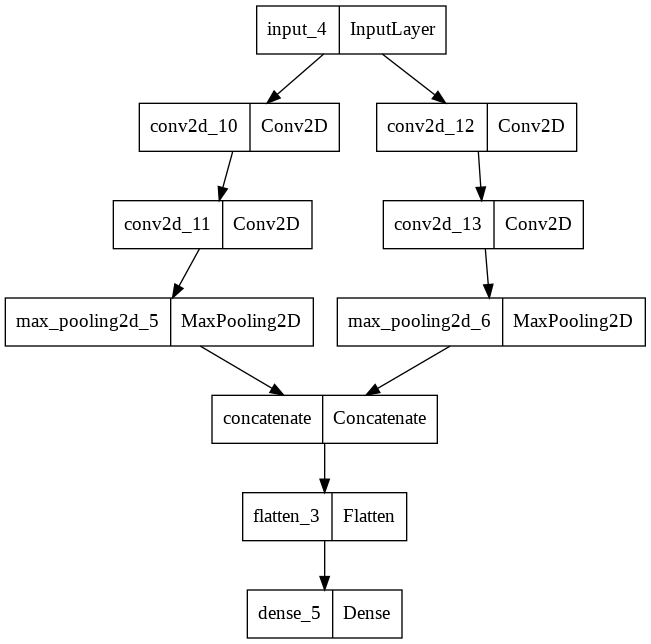

In [22]:
# Exp 3
# Возьмем за основу первую модель и добавим количество нитей

first_input = Input(shape=(x_train.shape[1:])) #(32, 32, 3)
x11= Conv2D(32, (3, 3),activation='relu',padding = 'same')(first_input)
x11= Conv2D(32, (3, 3),activation='relu',padding = 'same')(x11)
x11= MaxPooling2D(pool_size=(2, 2))(x11)
# x11= Flatten()(x11)

x12= Conv2D(16, (3, 3),activation='relu',padding = 'same')(first_input)
x12= Conv2D(16, (3, 3),activation='relu',padding = 'same')(x12)
x12= MaxPooling2D(pool_size=(2, 2))(x12)
# x12= Flatten()(x11)

merge_one = Concatenate(  axis =-1 )([x11, x12])

first_dense= Flatten()(merge_one)
first_dense=Dense(num_classes, activation='softmax')(first_dense)

model_stek = Model(inputs=first_input, outputs=first_dense)
ada_grad = tf.keras.optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=0.0)
sgd = tf.keras.optimizers.SGD()
model_stek.compile(optimizer=sgd, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


plot_model(model_stek,'model_stek.png')

In [23]:
model_stek.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 32)   896         ['input_4[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 32, 32, 16)   448         ['input_4[0][0]']                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_10[0][0]']              
                                                                                            

In [24]:
hist = model_stek.fit(x_train, y_train, epochs = 5, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 158s 126ms/step - loss: 1.8689 - accuracy: 0.3374 - val_loss: 1.7297 - val_accuracy: 0.3902
Epoch 2/5
1250/1250 [==============================] - 157s 126ms/step - loss: 1.5463 - accuracy: 0.4550 - val_loss: 1.4539 - val_accuracy: 0.4905
Epoch 3/5
1250/1250 [==============================] - 157s 126ms/step - loss: 1.3769 - accuracy: 0.5138 - val_loss: 1.3351 - val_accuracy: 0.5306
Epoch 4/5
1250/1250 [==============================] - 157s 126ms/step - loss: 1.2601 - accuracy: 0.5564 - val_loss: 1.2576 - val_accuracy: 0.5669
Epoch 5/5
1250/1250 [==============================] - 157s 125ms/step - loss: 1.1742 - accuracy: 0.5891 - val_loss: 1.2169 - val_accuracy: 0.5745


val_accuracy: 0.5745

наблюдаем прирост качества при добавлении второй нити с отличительными параметрами сверки и последующей конкатенацией

при этом количество обучаемых параметров 135 тыс (меньше, чем у предыдущей модели) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


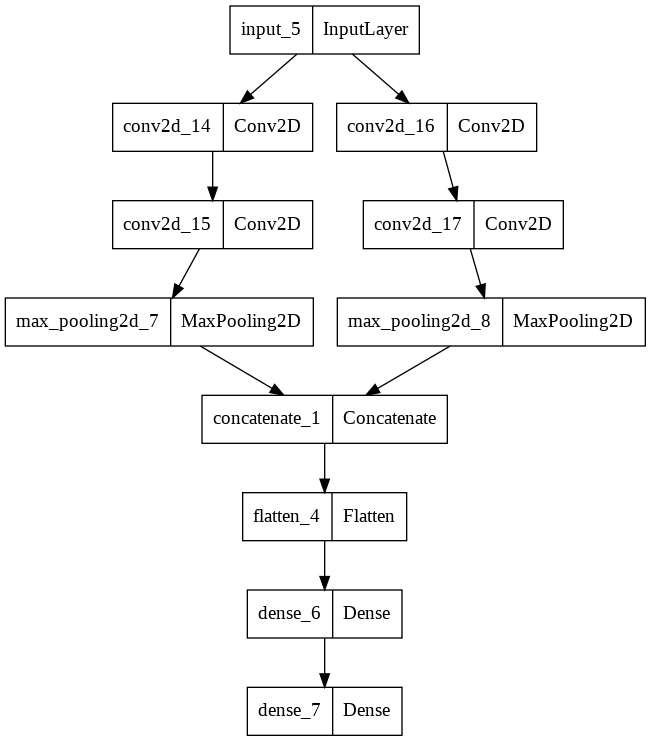

In [25]:
# Exp 4
# Возьмем за основу третью модель и добавим плотный слой перед выходным

first_input = Input(shape=(x_train.shape[1:])) #(32, 32, 3)
x11= Conv2D(32, (3, 3),activation='relu',padding = 'same')(first_input)
x11= Conv2D(32, (3, 3),activation='relu',padding = 'same')(x11)
x11= MaxPooling2D(pool_size=(2, 2))(x11)
# x11= Flatten()(x11)

x12= Conv2D(16, (3, 3),activation='relu',padding = 'same')(first_input)
x12= Conv2D(16, (3, 3),activation='relu',padding = 'same')(x12)
x12= MaxPooling2D(pool_size=(2, 2))(x12)
# x12= Flatten()(x11)

merge_one = Concatenate(  axis =-1 )([x11, x12])

first_dense= Flatten()(merge_one)
first_dense=Dense(256, activation='relu')(first_dense)
first_dense=Dense(num_classes, activation='softmax')(first_dense)

model_stek = Model(inputs=first_input, outputs=first_dense)
ada_grad = tf.keras.optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=0.0)
sgd = tf.keras.optimizers.SGD()
model_stek.compile(optimizer=sgd, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


plot_model(model_stek,'model_stek.png')

In [26]:
model_stek.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_14 (Conv2D)             (None, 32, 32, 32)   896         ['input_5[0][0]']                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 32, 32, 16)   448         ['input_5[0][0]']                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_14[0][0]']              
                                                                                            

In [27]:
hist = model_stek.fit(x_train, y_train, epochs = 5, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 182s 145ms/step - loss: 1.8720 - accuracy: 0.3306 - val_loss: 1.7464 - val_accuracy: 0.3906
Epoch 2/5
1250/1250 [==============================] - 182s 146ms/step - loss: 1.5276 - accuracy: 0.4581 - val_loss: 1.4280 - val_accuracy: 0.4950
Epoch 3/5
1250/1250 [==============================] - 182s 146ms/step - loss: 1.3281 - accuracy: 0.5265 - val_loss: 1.2709 - val_accuracy: 0.5515
Epoch 4/5
1250/1250 [==============================] - 182s 146ms/step - loss: 1.2024 - accuracy: 0.5736 - val_loss: 1.1993 - val_accuracy: 0.5793
Epoch 5/5
1250/1250 [==============================] - 182s 146ms/step - loss: 1.0993 - accuracy: 0.6116 - val_loss: 1.1194 - val_accuracy: 0.6071


val_accuracy: 0.6071

наблюдаем существенный прирост качества (с 0.575 до 0.607) при добавлении к третьей модели всего одного дополнительного плотного слоя перед выходным

но при этом имеем уже 3 млн обучаемых параметров

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


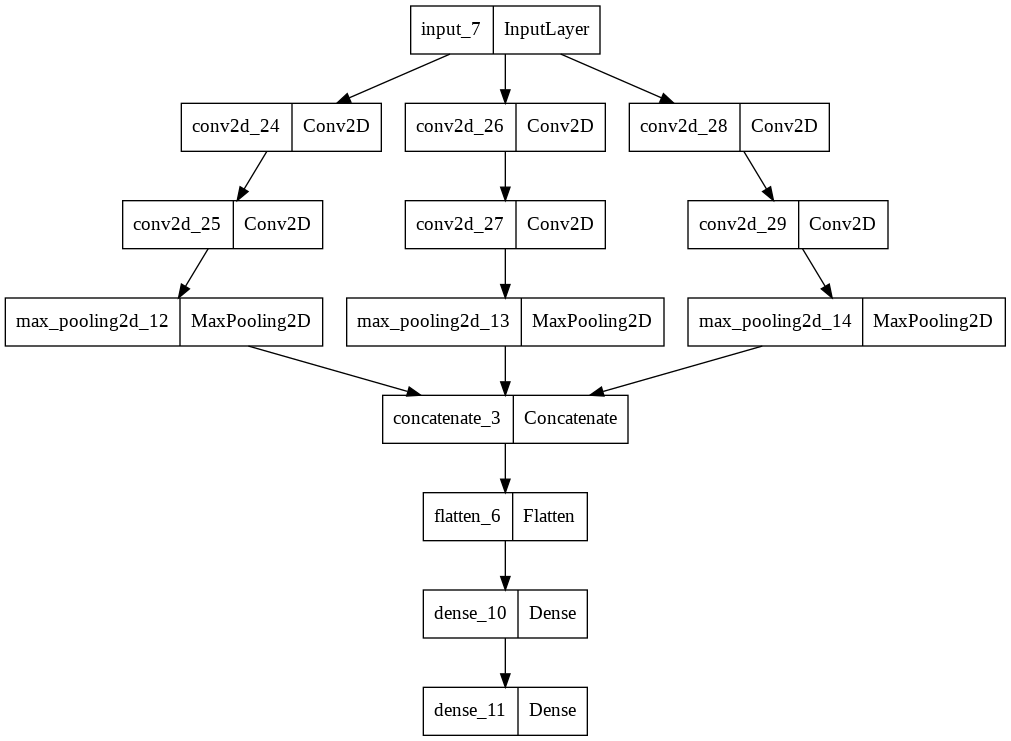

In [29]:
# Exp 5
# Возьмем за основу четвертую модель и добавим еще одну нить (двойная свертка 64) перед конкатенацией

first_input = Input(shape=(x_train.shape[1:])) #(32, 32, 3)
x11= Conv2D(32, (3, 3),activation='relu',padding = 'same')(first_input)
x11= Conv2D(32, (3, 3),activation='relu',padding = 'same')(x11)
x11= MaxPooling2D(pool_size=(2, 2))(x11)

x12= Conv2D(16, (3, 3),activation='relu',padding = 'same')(first_input)
x12= Conv2D(16, (3, 3),activation='relu',padding = 'same')(x12)
x12= MaxPooling2D(pool_size=(2, 2))(x12)

x13= Conv2D(64, (3, 3),activation='relu',padding = 'same')(first_input)
x13= Conv2D(64, (3, 3),activation='relu',padding = 'same')(x13)
x13= MaxPooling2D(pool_size=(2, 2))(x13)

merge_one = Concatenate(  axis =-1 )([x11, x12, x13])

first_dense= Flatten()(merge_one)
first_dense=Dense(256, activation='relu')(first_dense)
first_dense=Dense(num_classes, activation='softmax')(first_dense)

model_stek = Model(inputs=first_input, outputs=first_dense)
ada_grad = tf.keras.optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=0.0)
sgd = tf.keras.optimizers.SGD()
model_stek.compile(optimizer=sgd, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


plot_model(model_stek,'model_stek.png')

In [30]:
model_stek.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 32, 32, 32)   896         ['input_7[0][0]']                
                                                                                                  
 conv2d_26 (Conv2D)             (None, 32, 32, 16)   448         ['input_7[0][0]']                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 32, 32, 64)   1792        ['input_7[0][0]']                
                                                                                            

In [31]:
hist = model_stek.fit(x_train, y_train, epochs = 5, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 450s 360ms/step - loss: 1.8182 - accuracy: 0.3511 - val_loss: 1.5850 - val_accuracy: 0.4436
Epoch 2/5
1250/1250 [==============================] - 451s 361ms/step - loss: 1.4700 - accuracy: 0.4803 - val_loss: 1.3748 - val_accuracy: 0.5263
Epoch 3/5
1250/1250 [==============================] - 451s 361ms/step - loss: 1.2979 - accuracy: 0.5395 - val_loss: 1.3043 - val_accuracy: 0.5491
Epoch 4/5
1250/1250 [==============================] - 452s 362ms/step - loss: 1.1795 - accuracy: 0.5848 - val_loss: 1.1998 - val_accuracy: 0.5809
Epoch 5/5
1250/1250 [==============================] - 451s 361ms/step - loss: 1.0824 - accuracy: 0.6243 - val_loss: 1.1226 - val_accuracy: 0.6061


val_accuracy: 0.6061

наблюдаем то же самое качество модели, несмотря на дополнительную нить и увеличение параметров из-за нее более, чем в 2 раза

более 7 млн обучаемых параметров

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


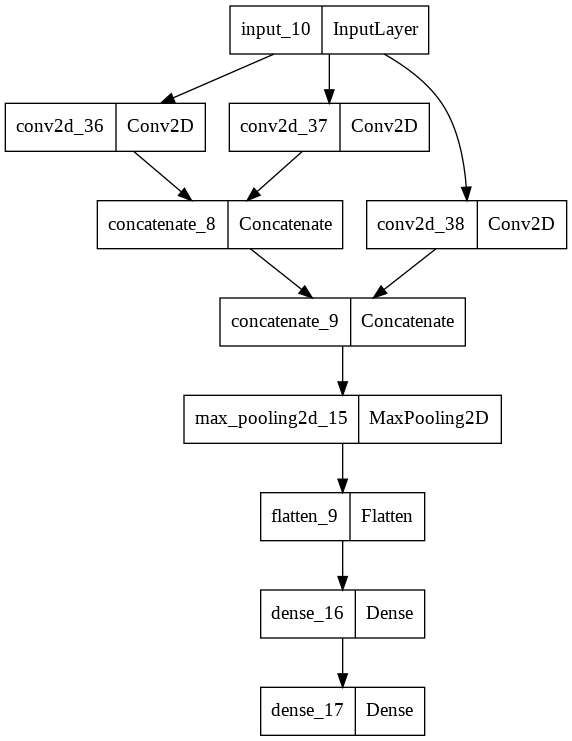

In [36]:
# Exp 6
# Возьмем новую произвольную структуру (простую, но достаточно разнообразную, на наш вгляд)

first_input = Input(shape=(x_train.shape[1:])) #(32, 32, 3)
x11= Conv2D(16, (3, 3),activation='relu',padding = 'same')(first_input)
x12= Conv2D(32, (3, 3),activation='relu',padding = 'same')(first_input)
x13= Conv2D(64, (3, 3),activation='relu',padding = 'same')(first_input)

merge_one = Concatenate(  axis =-1 )([x11, x12])
merge_two = Concatenate(  axis =-1 )([merge_one, x13])

merge_two= MaxPooling2D(pool_size=(2, 2))(merge_two)

# x11= MaxPooling2D(pool_size=(2, 2))(x11)

# x12= Conv2D(16, (3, 3),activation='relu',padding = 'same')(first_input)
# x12= Conv2D(16, (3, 3),activation='relu',padding = 'same')(x12)
# x12= MaxPooling2D(pool_size=(2, 2))(x12)

# x13= Conv2D(64, (3, 3),activation='relu',padding = 'same')(first_input)
# x13= Conv2D(64, (3, 3),activation='relu',padding = 'same')(x13)
# x13= MaxPooling2D(pool_size=(2, 2))(x13)

# merge_one = Concatenate(  axis =-1 )([x11, x12, x13])

first_dense= Flatten()(merge_two)
first_dense=Dense(256, activation='relu')(first_dense)
first_dense=Dense(num_classes, activation='softmax')(first_dense)

model_stek = Model(inputs=first_input, outputs=first_dense)
ada_grad = tf.keras.optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=0.0)
sgd = tf.keras.optimizers.SGD()
model_stek.compile(optimizer=sgd, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


plot_model(model_stek,'model_stek.png')

In [37]:
model_stek.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_36 (Conv2D)             (None, 32, 32, 16)   448         ['input_10[0][0]']               
                                                                                                  
 conv2d_37 (Conv2D)             (None, 32, 32, 32)   896         ['input_10[0][0]']               
                                                                                                  
 concatenate_8 (Concatenate)    (None, 32, 32, 48)   0           ['conv2d_36[0][0]',              
                                                                  'conv2d_37[0][0]']        

In [38]:
hist = model_stek.fit(x_train, y_train, epochs = 5, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 146s 117ms/step - loss: 1.8499 - accuracy: 0.3397 - val_loss: 1.6612 - val_accuracy: 0.4136
Epoch 2/5
1250/1250 [==============================] - 145s 116ms/step - loss: 1.5369 - accuracy: 0.4550 - val_loss: 1.4774 - val_accuracy: 0.4643
Epoch 3/5
1250/1250 [==============================] - 145s 116ms/step - loss: 1.3728 - accuracy: 0.5135 - val_loss: 1.3449 - val_accuracy: 0.5293
Epoch 4/5
1250/1250 [==============================] - 145s 116ms/step - loss: 1.2643 - accuracy: 0.5531 - val_loss: 1.2554 - val_accuracy: 0.5582
Epoch 5/5
1250/1250 [==============================] - 145s 116ms/step - loss: 1.1919 - accuracy: 0.5804 - val_loss: 1.2219 - val_accuracy: 0.5713


val_accuracy: 0.5713

те же 7 млн обучаемых параметров, как у предыдущей модели, но качество сильно ниже (0.571 против  0.606)

---

### Выводы:

- просто бездумное увеличение ширины или глубины модели не обязательно приводит к улучшениям, а иногда и ухудшает ее качество;
- при этом в целом, увеличение количества слоев, ядер и нитей в модели приводит к улучшению качества за счет увеличения сложности модели;
- лучший результат показала не самая глубокая и широкая модель (но и не самая плоская), поэтому важна именно архитектура, разнообразие и баланс (количество слоев, ядер, нитей), конфигурацию которых необходимо подбирать через эксперементы под каждый конкретный случай
- все тесты проводились на небольшом одинаковом количестве эпох, поэтому, возможно, качество некоторых моделей также дополнительно можно увеличить за счет увеличения количества эпох

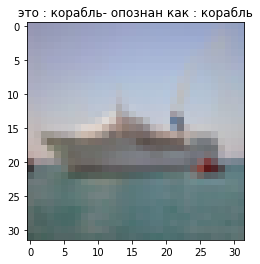

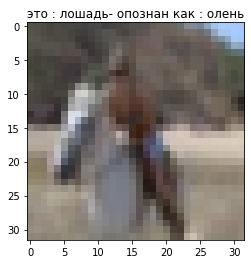

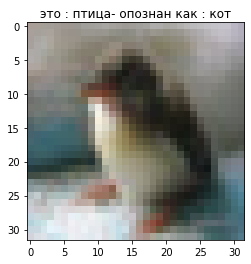

In [39]:
N_list = [1011, 9013, 2516]
for N in N_list:
    y_p=model_stek.predict(x_test[N:N+1][:,:,:])
    # y_p=model_stek.predict([x_test[N:N+1][:,:,:], x_test[N:N+1][:,:,:], x_test[N:N+1][:,:,:]])
    y_t = np.argmax(y_test[N:N+1], axis = 1 )
    y_i = np.argmax(y_p, axis = 1 )
    plt.imshow(x_test[N][:,:,:])
    plt.title('это : '+classes[y_t[0]]+'- опознан как : '+classes[y_i[0]])
    plt.show()